**Files required to run this:**

- `cleaned_dat_sem_shift.csv`: a .csv of semantic shifts from DatSemShift with properties discussed in our report, cleaned manually (i.e. ensure consistent formatting, punctuation, etc. in the senses).
- `english_relations.csv`: a .csv of every English relation in ConceptNet, because using the API is too slow (although due to the size of this file, it's not much faster using this). 

In [ ]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import torch

from collections import Counter
from collections import defaultdict
from functools import reduce
from matplotlib import patches
from scipy import stats
from scipy.special import softmax
from scipy.spatial import distance
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [ ]:
# Sentence embeddings

! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model = SentenceTransformer('whaleloops/phrase-bert')
embed_length = len(model.encode("test"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Read DatSemShift data, and create embeddings

datSemShift = pd.read_csv('../data/datasets/cleaned_dat_sem_shift.csv')
datSemShift.drop(datSemShift.columns[[0, 1, 2]], axis=1, inplace=True)
datSemShift.rename(columns={"meaning1_clean": "meaning1", "meaning2_clean": "meaning2"}, inplace=True)

df = pd.DataFrame(datSemShift)
print(df.shape)

senses = list(pd.concat([df['meaning1'], df['meaning2']]).unique())

embeddings = model.encode(senses)
embeds_dict = {}
for sense, embedding in zip(senses, embeddings):
  embeds_dict[sense] = embedding

(2941, 2)


In [ ]:
# Create dataframe of difference embeddings for DatSemShift shifts

# list of pairs (meaning1, meaning2) that have an embedding
meaning_pairs = [(row['meaning1'], row['meaning2']) for i, row in df.iterrows() if row['meaning1'] in embeds_dict and row['meaning2'] in embeds_dict]

# Dictionary of i -> [component i of every sense embedding of meaning1, in the order of senses in meaning_pairs]
m1_dict = {i : [embeds_dict[m1][i] for m1, m2 in meaning_pairs] for i in range(embed_length)} 

# Dictionary of i -> [component i of every sense embedding of meaning2, in the order of senses in meaning_pairs]
m2_dict = {i : [embeds_dict[m2][i] for m1, m2 in meaning_pairs] for i in range(embed_length)} 

m1_df = pd.DataFrame.from_dict(m1_dict)
m2_df = pd.DataFrame.from_dict(m2_dict)
dif_df = m2_df - m1_df

# Combine the 2 dataframes as a difference
embeds_df = dif_df

# PCA

Reduce embeddings first down to 50 dimensions, for easier GMM clustering

In [ ]:
scaler = StandardScaler()
scaler.fit(embeds_df)
embeds_scaled = scaler.transform(embeds_df)

num_pcs = 50
pca = PCA(n_components=num_pcs)
components = pca.fit_transform(embeds_scaled)
components_df = pd.DataFrame(data = components, 
                           columns = [f'PC{i}' for i in range(1, num_pcs+1)])
components_df.shape

(2941, 50)

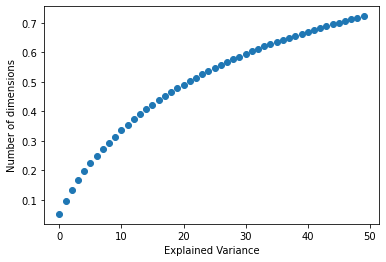

In [ ]:
# check explained variance

plt.xlabel("Explained Variance")
plt.ylabel("Number of dimensions")
plt.scatter(range(num_pcs), pca.explained_variance_ratio_.cumsum())

# merge back into word data
all_df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), [datSemShift, components_df])

# GMM

Create GMM clusters using principle components. We chose 50 clusters.

In [ ]:
num_components_used = 50 # Number of PCA components used
num_gmm = 50 # Number of clusters
estimator = GaussianMixture(n_components=num_gmm, covariance_type='spherical', init_params='kmeans', max_iter=20, random_state=24) # other covariance is "spherical", "diag", "tied"
estimator.fit(components_df[[f'PC{i}' for i in range(1, num_components_used+1)]])

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


GaussianMixture(covariance_type='spherical', max_iter=20, n_components=50,
                random_state=24)

In [ ]:
# Helper function to convert arrays to tensors
def toTensor(arr):
  return torch.tensor(arr, dtype = torch.float32)

# distance + cosine similarity from the means
for n in range(len(estimator.means_)):
  df['dist_' + str(n)] = np.linalg.norm(components_df[[f'PC{i}' for i in range(1, num_components_used+1)]] - estimator.means_[n], axis=1)
  df['sim_' + str(n)] = util.cos_sim(np.asarray(components_df[[f'PC{i}' for i in range(1, num_components_used+1)]]), toTensor(estimator.means_[n]))

# gmm gives a probability estimator, but it's kind of crap, and often gives 1.0 and 0.0
prob_df = pd.DataFrame(estimator.predict_proba(np.asarray(components_df[[f'PC{i}' for i in range(1, num_components_used+1)]])))
prob_df.columns = [f'prob_{i}' for i in range(len(estimator.means_))]

# they also label points by probability -- not really what we want, but interesting
label_df = pd.DataFrame(estimator.predict(np.asarray(components_df[[f'PC{i}' for i in range(1, num_components_used+1)]])))
label_df = label_df.rename(columns={0:'label'})

# Merge all that data into one dataframe
clusters_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [df, prob_df])
clusters_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [clusters_df, label_df])
all_df = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True, how='left'), [all_df, clusters_df[['label']]])

<ipython-input-22-6802ea1d6a30>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sim_' + str(n)] = util.cos_sim(np.asarray(components_df[[f'PC{i}' for i in range(1, num_components_used+1)]]), toTensor(estimator.means_[n]))
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


In [ ]:
clusters_df.head()

,meaning1,meaning2,dist_0,sim_0,dist_1,sim_1,dist_2,sim_2,dist_3,sim_3,...,prob_41,prob_42,prob_43,prob_44,prob_45,prob_46,prob_47,prob_48,prob_49,label
0,gunpowder,quick,32.126877,-0.226033,32.377975,-0.009948,30.881196,-0.034169,31.033895,0.062876,...,6.840135e-11,3.304946e-09,1.019616e-07,7.251521e-09,3.738846e-27,1.183787e-11,5.401548e-17,1.117217e-16,2.884409e-09,11
1,gunpowder,small quantity of something,26.709215,0.153110,32.129004,-0.081634,29.929018,-0.066296,28.939522,0.121046,...,1.521759e-08,1.099531e-14,2.814418e-08,4.441728e-11,1.082371e-30,4.993550e-14,1.832758e-19,3.000826e-13,2.175174e-10,33
2,August,harvest,26.302731,0.336894,34.705081,-0.144517,32.370653,-0.121952,29.447503,0.196036,...,4.107735e-09,1.607877e-24,1.571463e-11,2.115897e-12,2.161874e-23,2.270899e-16,3.458130e-19,4.083286e-12,2.819552e-05,34
3,common weed,potato,25.819458,0.009466,30.182459,-0.109033,27.996127,-0.111527,28.177297,0.015529,...,5.067434e-12,2.817694e-24,1.005004e-12,1.057272e-08,5.882553e-18,9.693474e-10,3.010155e-09,4.332573e-10,1.116987e-05,39
4,Easter,ladybird,29.772513,-0.190448,29.506512,0.064289,27.102748,0.118924,28.814948,0.092021,...,3.774728e-09,5.280241e-26,1.213317e-13,3.115495e-12,3.221276e-21,2.728584e-04,2.413144e-05,1.404125e-05,1.065379e-04,21


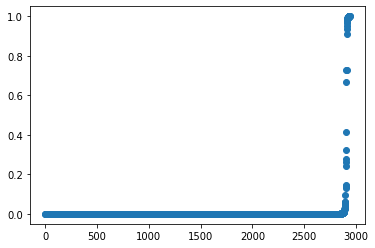

In [ ]:
# Check probabilities of being in each cluster; they're relatively binary

n = 32 # GMM cluster number
plt.scatter(range(len(clusters_df)), clusters_df.sort_values(by=(f'prob_{n}'))[f'prob_{n}'])

In [ ]:
# Check the shifts in each cluster, along with some relevant stats

n = 22 # gmm cluster number
max_display = 40 # maximum number of shifts to display in this cluster
cluster_shift_df = clusters_df[clusters_df['label'] == n].filter(['meaning1', 'meaning2', f'prob_{n}', 'label', f'dist_{n}', f'sim_{n}']).sort_values(by=('sim_' + str(n)), ascending=False)
print(f'In cluster {n}, there are {cluster_shift_df.shape[0]} shifts, with the top {max_display} displayed as follows:')
cluster_shift_df.head(max_display)

In cluster 22, there are 89 shifts, with the top 40 displayed as follows:


,meaning1,meaning2,prob_22,label,dist_22,sim_22
1977,to die,to fail of engine,0.999765,22,21.076471,0.687936
43,amber,electricity,0.999988,22,22.187817,0.678226
2066,to feel pity,to spare or to economize,0.908718,22,20.812562,0.647148
800,hare,pacemaker running,0.760586,22,20.753509,0.621162
566,face,surface,0.995016,22,19.728434,0.616367
276,candle,spark plug,0.999604,22,17.388605,0.614398
33,white of an egg,protein,0.990239,22,17.435304,0.613734
262,button on a dress,push button,0.999645,22,17.914107,0.603304
2516,to shoot,shuttle weaving instrument,0.966330,22,25.210413,0.598866
170,black,venous,0.999621,22,22.732724,0.598827


In [ ]:
# Calculate the AIC and BIC for GMMs with number of clusters between [min_cluster_count] and [max_cluster_count],
# to optimize the number of clusters

def aic_bic(min_cluster_count=1, max_cluster_count=100):
  n_components = np.arange(min_cluster_count, max_cluster_count)
  models = []
  for n in n_components:
    models.append(GaussianMixture(n, covariance_type='spherical', random_state=24).fit(components_df))
    if n % 25 == 0:
      print(f'Calculated AIC and BIC for GMM with {n-24} to {n} components')
  plt.plot(n_components, [m.bic(components_df) for m in models], label='BIC')
  plt.plot(n_components, [m.aic(components_df) for m in models], label='AIC')
  plt.legend(loc='best')
  plt.xlabel('n_components')

# Ontological graph analysis of clusters
---
Goal: use a large ontological knowledge graph (Wordnet, Conceptnet, etc.) to automatically classify the shifts in each cluster, since we've found them to be topic-based.

Process: For each cluster,
1. Extract the list of source meanings, as well as the list of target meanings
2. For each meaning in the source meaning: extract the related senses (recursively) of each meaning, using Wordnet or Conceptnet. Add the related senses (along with the meaning itself) to a multiset (a `Counter` in Python). 
  - Weight each related sense (add each sense to the multiset a specific number of times) depending on how many layers of recursion are needed to obtain that specific sense. If more layers of recursion are needed, then the sense is weighted less.
  - Set a maximum layer of recursion to prevent the senses from becoming too broad and unrelated. For Wordnet, we use a maximum layer of 3.
3. From the multiset: look at the most common related senses to determine the topic of the entire cluster. 
4. Divide the number of times the most common related sense appears in the multiset by the number of shifts in the cluster, as a rough measure of how well the cluster conforms to a specific topic. As a very broad rule of thumb, anything over 0.3 is pretty good and should be examined.

We are currently using Wordnet for the graph generated in the paper.

In [ ]:
# Get the top topics of a cluster, given a cluster number, maximum number of recursive layers, and a knowledge graph.
# Essentially just calls the corresponding helper functions

def get_cluster_topic(gmm_cluster_num, max_layers=3, source='Wordnet'):
  sources = list(clusters_df[clusters_df['label'] == gmm_cluster_num].loc[:,'meaning1'].dropna())
  targets = list(clusters_df[clusters_df['label'] == gmm_cluster_num].loc[:,'meaning2'].dropna())

  if source == 'Conceptnet':
    sources_topics = get_topics_conceptnet(sources, max_layers)
    targets_topics = get_topics_conceptnet(targets, max_layers)
  elif source == 'Wordnet':
    sources_topics = get_topics_wordnet(sources, max_layers)
    targets_topics = get_topics_wordnet(targets, max_layers)

  return sources_topics, targets_topics

In [ ]:
# Print all the information about a cluster and its topic

def print_cluster_topics(gmm_cluster_num, max_layers=3, source='Wordnet'):
  sources_topics, targets_topics = get_cluster_topic(gmm_cluster_num, max_layers=max_layers, source=source)
  size = len(clusters_df[clusters_df['label'] == gmm_cluster_num])
  print(f'For cluster {gmm_cluster_num} (with {size} elements)')
  print(f'the most common source topics are, with accuracy {sources_topics.most_common(1)[0][1]/size}:')
  print(sources_topics.most_common(10))
  print(f'To check if that\'s accurate, here are the most common source senses:')
  print(Counter(list(clusters_df[clusters_df['label'] == gmm_cluster_num].loc[:,'meaning1'].dropna())).most_common(25))
  print()
  print(f'the most common target topics are, with accuracy {targets_topics.most_common(1)[0][1]/size}:')
  print(targets_topics.most_common(10))
  print(f'To check if that\'s accurate, here are the most common target senses:')
  print(Counter(list(clusters_df[clusters_df['label'] == gmm_cluster_num].loc[:,'meaning2'].dropna())).most_common(25))
  print('---------------------------------')

In [ ]:
# A list of words to ignore, in terms of searching through Conceptnet/Wordnet

filler_words = {'to', 'or', 'in', 'some', 'with', 'of', 'a', 'the', 'for', 'by', 'be'}

## Conceptnet

In [ ]:
# Read all the English relations in Conceptnet into a pandas dataframe, because it's too slow otherwise

conceptnet = pd.read_csv("drive/MyDrive/FURSP/english_relations.csv")
conceptnet.drop(columns=['Unnamed: 0'], inplace=True)
print(set(conceptnet['Relationship']))
conceptnet.head()

{'dbpedia/product', 'dbpedia/influencedBy', 'MotivatedByGoal', 'SimilarTo', 'UsedFor', 'dbpedia/genus', 'dbpedia/leader', 'InstanceOf', 'DerivedFrom', 'SymbolOf', 'dbpedia/knownFor', 'NotCapableOf', 'NotHasProperty', 'PartOf', 'CapableOf', 'DefinedAs', 'HasSubevent', 'dbpedia/occupation', 'HasA', 'Antonym', 'dbpedia/capital', 'Desires', 'HasContext', 'HasProperty', 'DistinctFrom', 'dbpedia/genre', 'CausesDesire', 'MannerOf', 'HasPrerequisite', 'NotDesires', 'EtymologicallyRelatedTo', 'HasFirstSubevent', 'ReceivesAction', 'IsA', 'Entails', 'Causes', 'CreatedBy', 'FormOf', 'LocatedNear', 'dbpedia/field', 'HasLastSubevent', 'dbpedia/language', 'MadeOf', 'AtLocation', 'RelatedTo', 'Synonym', 'EtymologicallyDerivedFrom'}


,Word 1,Word 2,Relationship
0,0,1,Antonym
1,12_hour_clock,24_hour_clock,Antonym
2,24_hour_clock,12_hour_clock,Antonym
3,5,3,Antonym
4,a.c,d.c,Antonym


In [ ]:
# Dictionary of sense : related senses (so that one sense isn't checked multiple times)
conceptnet_dict = {}

# Get the directly related concepts to a sense
def get_related_concepts(c):
  if c in conceptnet_dict:
    return conceptnet_dict[c]
  else:
    set1 = set(conceptnet[(conceptnet['Word 1'] == c) & (conceptnet['Relationship'].isin({'IsA', 'PartOf', 'SymbolOf'}))]['Word 2'])
    set2 = set(conceptnet[(conceptnet['Word 2'] == c) & (conceptnet['Relationship'].isin({'HasProperty', 'ReceivesAction', 'Causes', 'CreatedBy'}))]['Word 1'])
    set1.update(set2)
    conceptnet_dict[c] = set1
  return set1

# Get the related concepts to a list of concepts
def get_topics_conceptnet(concepts, max_layers=3):
  hypernyms = Counter()
  concepts_counter = Counter(concepts)
  print(f'Total number of concepts: {len(concepts_counter)}')

  for i, concept in enumerate(concepts_counter):
    print(f'Starting the {i+1}th concept: {concept}')
    strs = [s.strip() for s in re.split(' |_', concept) if s != '' and s not in filler_words]
    hyps = set()

    indices = [(i, j) for i in range(len(strs)) for j in range(i, len(strs)+1)]

    for i,j in indices:
      perm_str = '_'.join(strs[i:j])
      perm_hyps = get_related_concepts(perm_str)
      hyps.update(get_topics_conceptnet_helper(perm_hyps, max_layers-1))

    for _ in range(concepts_counter[concept]):
      hypernyms.update(hyps)

  return hypernyms

# Recursive helper to get_topics_conceptnet
def get_topics_conceptnet_helper(concepts, max_layers):
  if max_layers == 0:
    return concepts

  hypernyms = set(concepts)
  
  for concept in concepts.copy():
    hyps = get_related_concepts(concept)
    hyps.update(get_topics_conceptnet_helper(hyps, max_layers-1))

    hypernyms.update(hyps)

  return hypernyms

In [ ]:
# Try it out!

# print_cluster_topics(5, max_layers=2, source='Conceptnet')

Even though Conceptnet contains much more information than Wordnet, it is unfortunately super slow (even with the dataframe), so we move on to using Wordnet.

# Wordnet

In [ ]:
# Wordnet
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Some helper functions to deal with lists-in-lists (since Wordnet returns related synsets in that format)

def flatten(x):
  if type(x) is list:
    return [a for i in x for a in flatten(i)]
  else:
    return [x]

# return elements at depth <depth> in list <lst>
def elems_at_depth(lst, depth):
  if type(lst) is not list and depth == 0:
    return [lst]
  elif type(lst) is not list or depth == 0:
    return []
  else:
    elems = []  
    for elem in lst:
      elems.extend(elems_at_depth(elem, depth - 1))
  
    return elems

In [ ]:
def get_topics_wordnet(concepts, max_layers=3):
  concepts_count = Counter(concepts)
  hypernyms = Counter()

  for concept in concepts_count:
    strs = [s.strip().lower() for s in re.split(" ", concept) if s != '']
    synsets = set()
    hyps = defaultdict(set)

    # Go through every contiguous substring of words in concept
    indices = [(i, j) for i in range(len(strs)) for j in range(i+1, len(strs)+1)]
    for i,j in indices:
      s = '_'.join(strs[i:j])
      if s in filler_words:
        continue

      synsets_to_add = wn.synsets(s)
      if len(synsets_to_add) > 0:
        synsets.update([synsets_to_add[0]])
    
    for synset in synsets:
      relations = {(lambda s: s.hypernyms()), (lambda s: s.entailments()), (lambda s: s.causes()), (lambda s: s.also_sees()), 
                   (lambda s: s.verb_groups()), (lambda s: s.similar_tos()), (lambda s: s.attributes())}
      #relations = {(lambda s: s.hypernyms()), (lambda s: s.entailments()), (lambda s: s.causes()), (lambda s: s.also_sees()), 
      #              (lambda s: s.similar_tos()), (lambda s: s.attributes())}

      for r in relations:
        for d in range(1, max_layers):
          hyp_synsets = elems_at_depth(synset.mst(r), d)
          hyps[d].update(set(flatten([s.lemma_names('eng') for s in hyp_synsets])))

    for _ in range(concepts_count[concept]):
      for (d, s) in hyps.items():
        for _ in range(d):
          hypernyms.update(s)

  return hypernyms

In [ ]:
# Print out the contents of the GMMs clusters

for gmm_cluster_num in range(num_gmm):
  print_cluster_topics(gmm_cluster_num, max_layers=3, source='Wordnet')

# Visualizing GMM clusters

<Figure size 1440x1440 with 0 Axes>

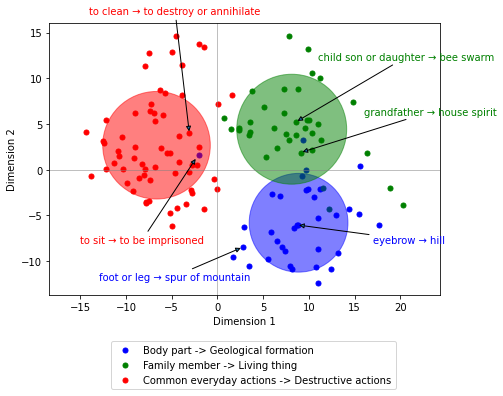

In [ ]:
# function for making ellipses. can't be more colors than clusters, or it'll throw an error

colors = ['blue', 'green', 'red', 'purple', 'grey']
clusters_nums = [31, 3, 46]
labels = {31: 'Body part -> Geological formation',
          3: 'Family member -> Living thing',
          46: 'Common everyday actions -> Destructive actions'}  
          
labels.update({
    17: 'Body part -> Body of water',
    26: 'Parts and actions related to body -> Person of high rank',
    22: 'Celestial Object -> Date/Calendar'})


def make_ellipses(gmm, ax, dim1, dim2):
    for n, color in zip(clusters_nums, colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 3.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = patches.Ellipse(
            [gmm.means_[n, dim1], gmm.means_[n, dim2]], v[0], v[1], 180 + angle, color=color
        )


        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")
  
scatter_df = all_df[all_df['label'].isin(clusters_nums)]

plt.figure(figsize=(20, 20))
fig, ax = plt.subplots()

ax.axhline(y=0, color='grey', linewidth=.5)
ax.axvline(x=0, color='grey', linewidth=.5)

e1, e2 = 0, 2

pc1, pc2 = f'PC{e1+1}', f'PC{e2+1}'
size = 25

for (i, n) in enumerate(clusters_nums):
  ax.scatter(scatter_df[scatter_df['label'] == n][pc1], scatter_df[scatter_df['label'] == n][pc2], c=colors[i], s=size, cmap='viridis', label=labels[n])

ax.legend(bbox_to_anchor =(0.9, -0.15))
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Annotate individual points
def get_label(row):
  return (f"{row['meaning1']} → {row['meaning2']}"), (row[pc1], row[pc2])

label_nums = {657: (-13, -12), 
              555: (17, -8), 
              302: (11, 12),
              736: (16, 6),
              2535: (-15, -8), 
              1923: (-14, 17)}
# foot or leg -> spur of mountain
# eyebrow -> hill
# child son or daughter -> bee swarm
# grandfather -> house spirit
# to sit -> to be imprisoned
# to clean -> to destroy or annihilate

for (i, label_num) in enumerate(label_nums):
  label = get_label(all_df.iloc[label_num])
  ax.annotate(label[0], label[1], label_nums[label_num], arrowprops=dict(arrowstyle="-|>"), color=colors[i//2])

ax.figure.set_size_inches(7, 5)

make_ellipses(estimator, ax, e1, e2)

image_format = 'svg'
image_name = 'myimage.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

In [ ]:
n = 25 # gmm cluster number
print(clusters_df[clusters_df['label'] == n].filter(['meaning1', 'meaning2', f'prob_{n}', 'label', f'dist_{n}', f'sim_{n}']).sort_values(by=(f'sim_{n}'), ascending=False).shape[0])
clusters_df[clusters_df['label'] == n].filter(['meaning1', 'meaning2', f'prob_{n}', 'label', f'dist_{n}', f'sim_{n}']).sort_values(by=(f'sim_{n}'), ascending=False).head(40)

50


,meaning1,meaning2,prob_25,label,dist_25,sim_25
2151,to go out,to fade or lose color,1.000000,25,19.370433,0.794878
2148,to go out,to disappear,0.999994,25,14.330898,0.765517
2540,to sit down,to shrink of textile,0.999861,25,17.572004,0.743464
2025,to enter,to shrink of textile,0.999985,25,21.916832,0.708033
2335,to pass by,to fade or lose color,0.999984,25,19.721598,0.691264
1792,to be keen of,to grow numb,0.999977,25,16.519720,0.684276
2634,to take,to subtract,0.991566,25,15.276201,0.658933
2225,to kill,to extinguish,0.991681,25,18.042325,0.650733
2099,to get tired,to grow numb,0.998631,25,14.138669,0.638087
2152,to go out,to fall of rain or snow,0.999765,25,18.757121,0.632114
